In [15]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
import numpy as np
from helper_functions import set_seeds

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [32]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

num_layers_to_keep_grad = 20
total_layers = len(list(pretrained_vit.parameters()))

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False


# 3. Freeze the base parameters
for i, parameter in enumerate(pretrained_vit.parameters()):
    if i >= total_layers - num_layers_to_keep_grad:
        parameter.requires_grad = True


    
# 4. Change the classifier head 
class_names = ['no','yes']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

In [33]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              Partial
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   Partial
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [34]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [45]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

dataset_path = "dataset"
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a fixed size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values
])
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Define the percentage of data to be used for training
train_percentage = 0.8

# Calculate the number of samples for training and testing
num_samples = len(dataset)
num_train = int(train_percentage * num_samples)
num_test = num_samples - num_train

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [num_train, num_test])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes


In [43]:

# NUM_WORKERS = os.cpu_count()

# def create_dataloaders(
#     train_dir: str, 
#     test_dir: str, 
#     transform: transforms.Compose, 
#     batch_size: int, 
#     num_workers: int=NUM_WORKERS
# ):

#   # Use ImageFolder to create dataset(s)
#   train_data = datasets.ImageFolder(train_dir, transform=transform)
#   test_data = datasets.ImageFolder(test_dir, transform=transform)

#   # Get class names
#   class_names = train_data.classes

#   # Turn images into data loaders
#   train_dataloader = DataLoader(
#       train_data,
#       batch_size=batch_size,
#       shuffle=True,
#       num_workers=num_workers,
#       pin_memory=True,
#   )
#   test_dataloader = DataLoader(
#       test_data,
#       batch_size=batch_size,
#       shuffle=False,
#       num_workers=num_workers,
#       pin_memory=True,
#   )

#   return train_dataloader, test_dataloader, class_names

In [12]:
# Setup dataloaders
# train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
#                                                                                                      test_dir=test_dir,
#                                                                                                      transform=pretrained_vit_transforms,
#                                                                                                      batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [47]:
import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_loader,
                                      test_dataloader=test_loader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7873 | train_acc: 0.6901 | test_loss: 0.3655 | test_acc: 0.8385
Epoch: 2 | train_loss: 0.4335 | train_acc: 0.8164 | test_loss: 0.3381 | test_acc: 0.8542
Epoch: 3 | train_loss: 0.3487 | train_acc: 0.8503 | test_loss: 0.2572 | test_acc: 0.8854
Epoch: 4 | train_loss: 0.2967 | train_acc: 0.8633 | test_loss: 0.2229 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.2296 | train_acc: 0.9154 | test_loss: 0.3408 | test_acc: 0.8490
Epoch: 6 | train_loss: 0.2055 | train_acc: 0.9076 | test_loss: 0.1511 | test_acc: 0.9479
Epoch: 7 | train_loss: 0.1369 | train_acc: 0.9531 | test_loss: 0.0711 | test_acc: 0.9792
Epoch: 8 | train_loss: 0.0935 | train_acc: 0.9583 | test_loss: 0.0960 | test_acc: 0.9531
Epoch: 9 | train_loss: 0.1153 | train_acc: 0.9622 | test_loss: 0.1256 | test_acc: 0.9688
Epoch: 10 | train_loss: 0.0609 | train_acc: 0.9818 | test_loss: 0.0345 | test_acc: 0.9896


pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


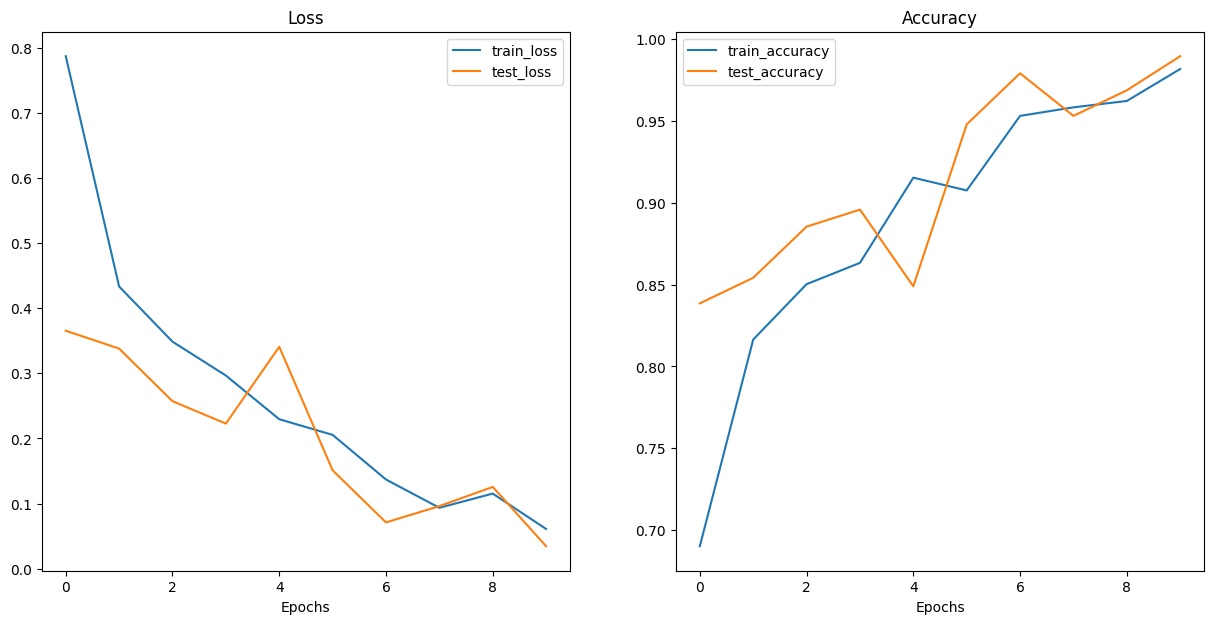

In [48]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 